# Digit Recognition

Build a deep learning model to classify handwritten digits. You can use convolutional neural networks (CNNs) or other machine learning algorithms for this task.

In [1]:
# Importing necessary libraries for PyTorch and data visualization
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms

# Setting a random seed for reproducibility
random_seed = 1
torch.backends.cudnn.enabled = False  # Disabling CuDNN for deterministic results
_ = torch.manual_seed(random_seed)  # Setting manual seed for random number generation

## Preparing the dataset

In [2]:
# Create useful folders
folders = ["../data", "../results/", "../results/digit-recognition/"]
for f in folders:
    if not os.path.exists(f):
        os.mkdir(f)

In [3]:
# Defining batch sizes for training and testing data
batch_size_train = 64
batch_size_test = 1000

# Defining data transformations, including converting images to tensors and normalizing pixel values
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# Loading MNIST dataset for training and testing
# For training data, setting train=True, downloading if not available, and applying transformations
train_dataset = datasets.MNIST("../data", train=True, download=True, transform=transform)

# For testing data, setting train=False, not downloading, and applying transformations
train_dataset = datasets.MNIST("../data", train=False, transform=transform)

# Creating data loaders for efficient batch processing during training and testing
# For training data, using DataLoader with specified batch size and shuffling the data
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size_train, shuffle=True
)

# For testing data, using DataLoader with specified batch size and shuffling the data
test_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size_test, shuffle=True
)

Shape of example_data: torch.Size([1000, 1, 28, 28])


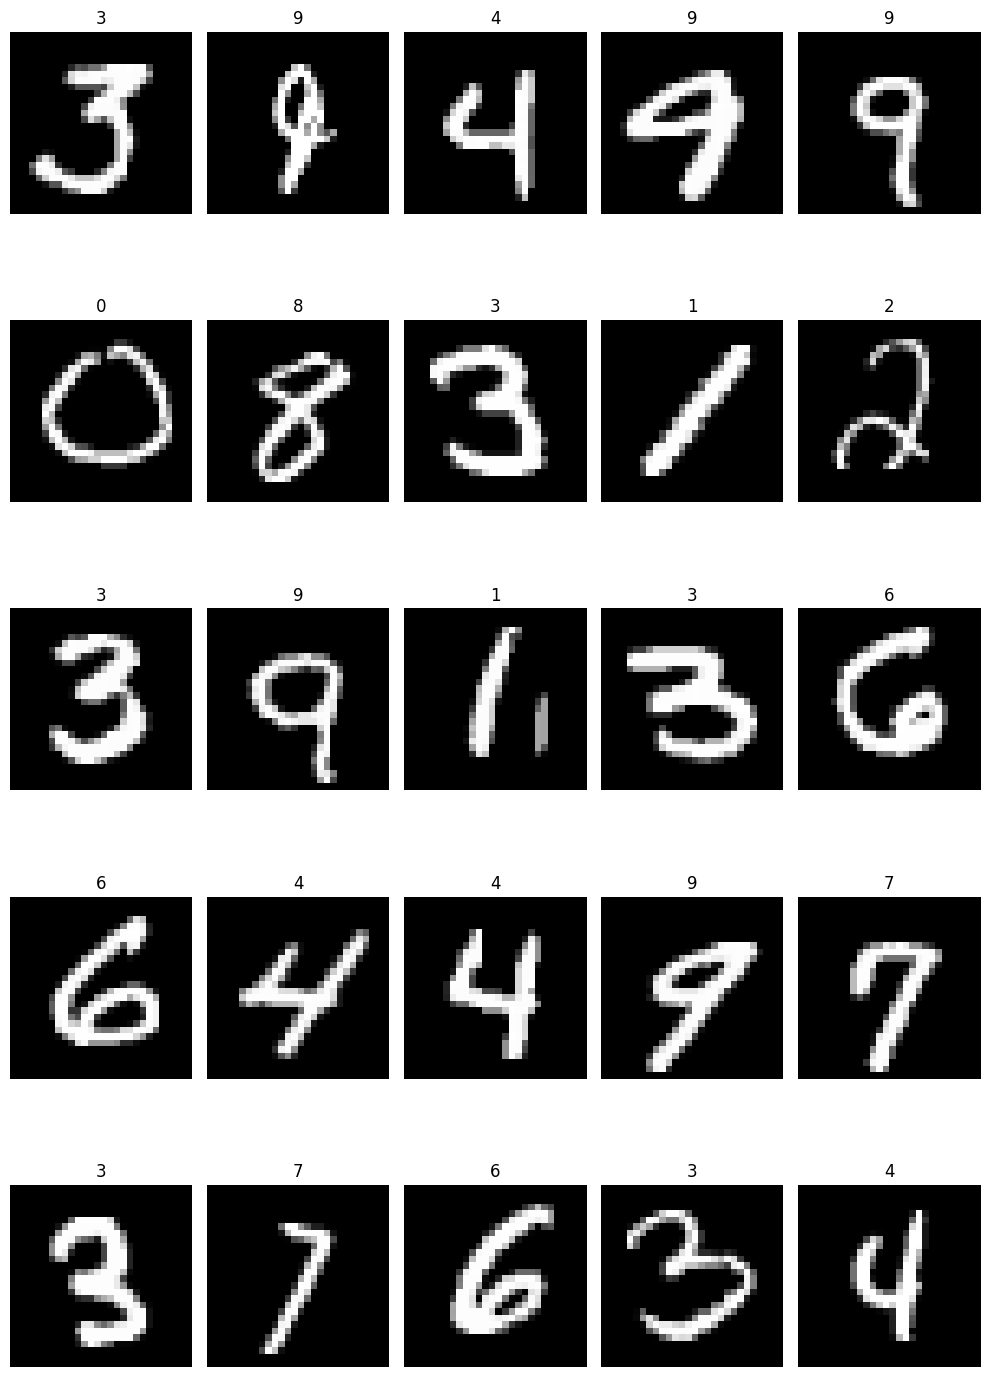

In [4]:
# Getting one batch of examples from the test_loader
batch_idx, (example_data, example_targets) = next(enumerate(test_loader))

# Printing the shape of the example_data tensor
print("Shape of example_data:", example_data.shape)

# Plotting the first images along with their labels
fig, axes = plt.subplots(5, 5, figsize=(10, 15))

for i, ax in enumerate(axes.flat):
    ax.imshow(example_data[i][0], cmap="gray", interpolation="none")
    ax.set_title("{}".format(example_targets[i]))
    ax.axis('off')

plt.tight_layout()
plt.show()

## Building the network

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Define convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.25)
        )

        # Define fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        output = F.log_softmax(x, dim=1)
        return output

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

In [6]:
learning_rate = 1
n_epochs = 3
train_losses = []

# Create an instance of the model
model = Net()
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
print(model)

Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.25, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [10]:
from torch.utils.tensorboard import SummaryWriter
import shutil

# Path to the log directory
log_dir = "./runs/digit-recognition/"

# Remove the previous log directory (if it exists)
shutil.rmtree(log_dir, ignore_errors=True)

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir=log_dir)

# Visualize the network architecture
dummy_input = torch.rand(1, 1, 28, 28)  # Create a dummy input tensor
writer.add_graph(model, dummy_input)

## Training the model

In [12]:
n1, n2

(10000, 157)

In [11]:
log_interval = 50
n1 = len(train_loader.dataset)
n2 = len(train_loader)
def train(epoch):
    """
    Training function for the neural network model.

    Args:
        epoch (int): Current epoch number.
    """
    model.train()  # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Zero the gradients
        output = model(data)  # Forward pass
        loss = F.nll_loss(output, target)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Print training progress and store losses
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    n1,
                    100.0 * batch_idx / n2,
                    loss.item(),
                )
            )
            train_losses.append(loss.item())
    # Save model and optimizer states at the end of each epoch
    torch.save(model.state_dict(), '../results/digit-recognition/model_epoch_{}.pth'.format(epoch))
    torch.save(optimizer.state_dict(), '../results/digit-recognition/optimizer_epoch_{}.pth'.format(epoch))

def test():
    """
    Evaluation function for the neural network model on the test set.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)  # Forward pass
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # Calculate the loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the predicted labels
            correct += (
                pred.eq(target.view_as(pred)).sum().item()
            )  # Count correct predictions

    test_loss /= len(test_loader.dataset)
    # Print test set results
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

In [15]:
# Training and testing loop
for epoch in range(1, n_epochs + 1):
    train(epoch)  # Train the model for the current epoch
    test()  # Evaluate the model on the test set after training

Train Epoch: 1 [0/10000 (0%)]	Loss: 2.370328
Train Epoch: 1 [3200/10000 (32%)]	Loss: 0.323276
Train Epoch: 1 [6400/10000 (64%)]	Loss: 0.179752
Train Epoch: 1 [9600/10000 (96%)]	Loss: 0.152416

Test set: Average loss: 0.0775, Accuracy: 9758/10000 (98%)

Train Epoch: 2 [0/10000 (0%)]	Loss: 0.062099
Train Epoch: 2 [3200/10000 (32%)]	Loss: 0.168878
Train Epoch: 2 [6400/10000 (64%)]	Loss: 0.178330
Train Epoch: 2 [9600/10000 (96%)]	Loss: 0.188065

Test set: Average loss: 0.0409, Accuracy: 9867/10000 (99%)

Train Epoch: 3 [0/10000 (0%)]	Loss: 0.028604
Train Epoch: 3 [3200/10000 (32%)]	Loss: 0.065200
Train Epoch: 3 [6400/10000 (64%)]	Loss: 0.066105
Train Epoch: 3 [9600/10000 (96%)]	Loss: 0.233387

Test set: Average loss: 0.0283, Accuracy: 9919/10000 (99%)



## Evaluating the Model's Performance

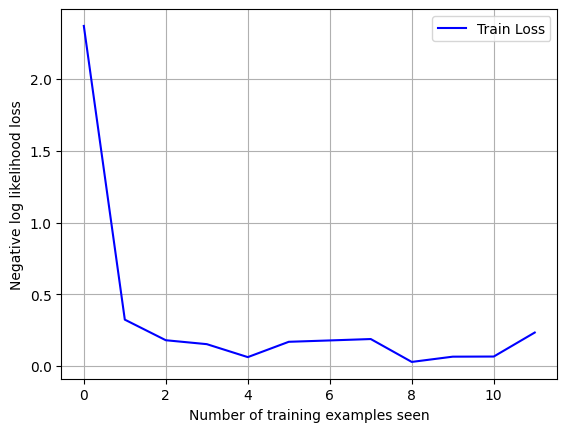

In [20]:
# Create a new figure for plotting
fig = plt.figure()

# Plot training losses as a blue line
plt.plot(train_losses, color="blue")
plt.grid(True)

# Add legend and labels
plt.legend(["Train Loss"], loc="upper right")
plt.xlabel("Number of training examples seen")
plt.ylabel("Negative log likelihood loss")

# Display the plot
plt.show()

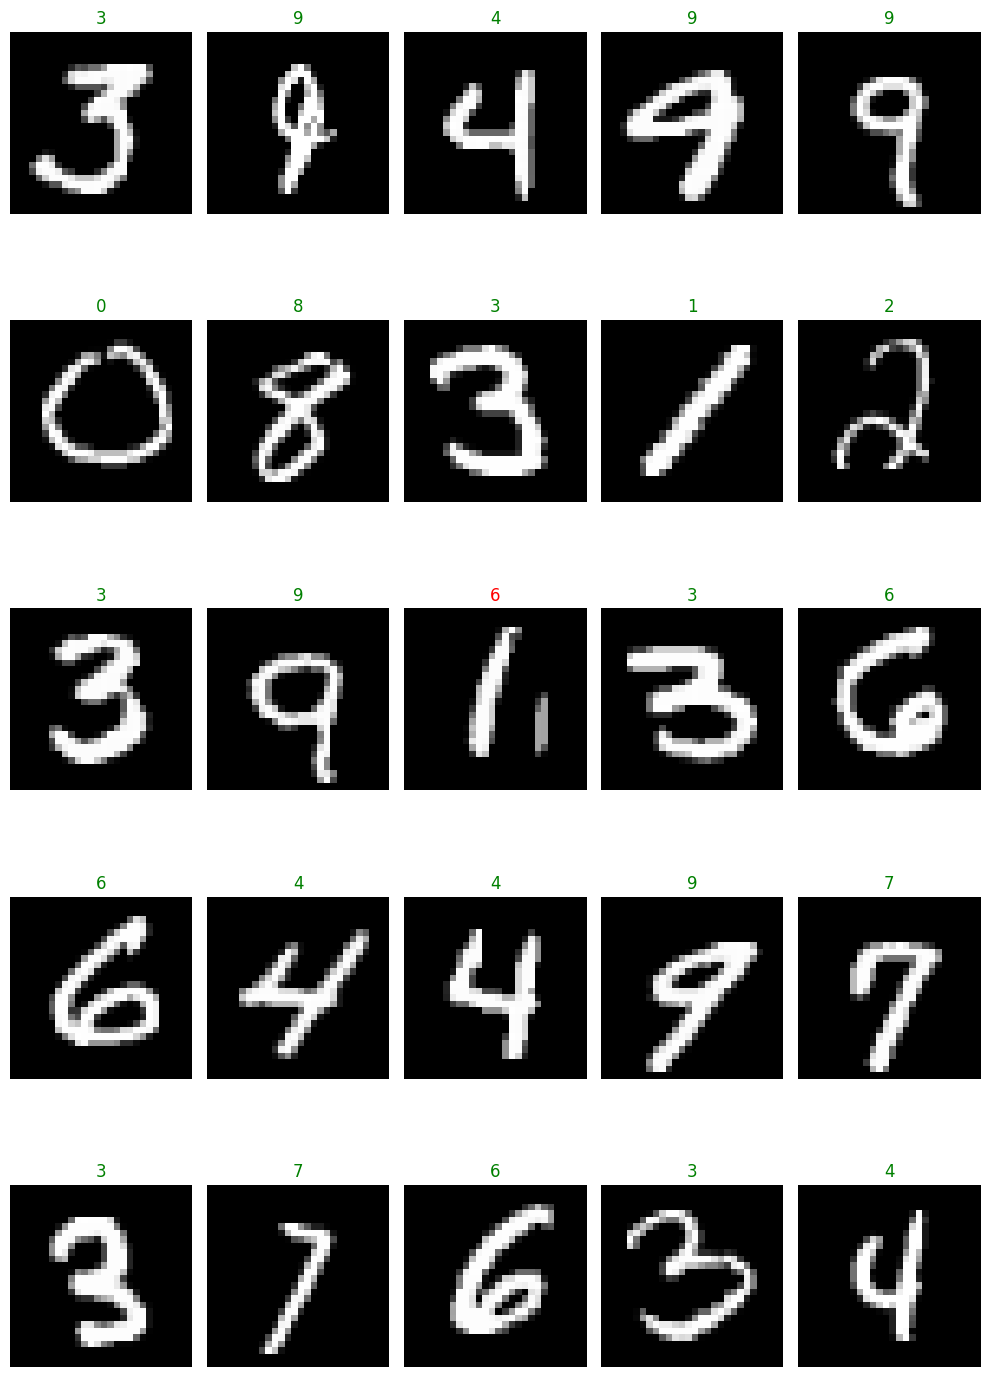

In [23]:
with torch.no_grad():
    # Disable gradient calculation
    output = model(example_data)  # Forward pass of the model with example_data
    fig, axes = plt.subplots(5, 5, figsize=(10, 15))  # Create a 3x4 grid of subplots
    predictions = output.argmax(dim=1)  # Calculate predictions once

    # Iterate over each subplot
    for i, ax in enumerate(axes.flat):
        ax.imshow(example_data[i][0], cmap="gray", interpolation="none")
        prediction = predictions[i].item()
        target = example_targets[i].item()
        ax.set_title(str(prediction), color='green' if prediction == target else 'red')
        ax.axis('off')  # Hide axis labels

    plt.tight_layout()  # Adjust layout
    plt.show()